# INTRNLP Twitter Sentiment Analysis

Yes.

# Import Modules

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re
import string
import os

# Load Dataset

In [2]:
def check_data_exist(data):
    return os.path.exists(data)

In [3]:
if check_data_exist("all_tweets.csv"):
    data = pd.read_csv("all_tweets.csv")
    data.drop(["Unnamed: 0"], inplace=True, axis=1)
else:
    for i in range(0, 24):
        if i == 0:
            data = pd.read_csv(f"Data/tweets_{i}.csv")
        else:
            append_data = pd.read_csv(f"Data/tweets_{i}.csv")
            data.append(append_data, ignore_index=True)
    data.to_csv("all_tweets.csv")

In [4]:
data.head(10)

,tweet_id,author_id,created_at_utc+8,lang,text
0,1264847297260605441,303106526,2020-05-25 17:14:30,tl,@alphangela bes wag ganyan ang attitude char i...
1,1264847299030597632,2647675584,2020-05-25 17:14:30,en,Bridgetowne yow
2,1264847299198414848,1074247547907174401,2020-05-25 17:14:30,tl,@Kookie07Jeon Can't stop laughing tf HAHAHAHAH...
3,1264847299210928128,1010402467878658048,2020-05-25 17:14:30,tl,@azilhanna09 HAHAHAHHAHAHAHHAAA ML NA LANG
4,1264847301568159746,947031284177502208,2020-05-25 17:14:31,en,One of my fav🤧♥️\n#백현 #BAEKHYUN #엑소 #EXO #wear...
5,1264847304604839936,1344240528,2020-05-25 17:14:31,tl,Wag tayo magmeryenda kasi magsamgyeopsal party...
6,1264847305389142016,65833115,2020-05-25 17:14:31,tl,@jeshyang Sadyang hindi lang talaga nag work y...
7,1264847306760712197,2862640171,2020-05-25 17:14:32,und,@giegiedc Ohhhh
8,1264847307943473152,569607182,2020-05-25 17:14:32,en,@killakushla Loveyou!!!
9,1264847310736900097,2565331939,2020-05-25 17:14:33,tl,@YusepengC Huy!!! AHAHAHA


# Preprocessing

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   tweet_id          250000 non-null  int64 
 1   author_id         250000 non-null  int64 
 2   created_at_utc+8  250000 non-null  object
 3   lang              250000 non-null  object
 4   text              250000 non-null  object
dtypes: int64(2), object(3)
memory usage: 9.5+ MB


Let's find out how many English tweets are available from the 250,000 tweets gathered.

In [6]:
data["lang"].value_counts()

tl     136908
en      73144
und     21238
in       7276
es       1851
it        973
tr        907
ht        887
et        732
pt        646
nl        576
fr        504
pl        458
de        406
ja        374
hi        344
no        254
ca        247
cy        244
eu        242
ko        202
sv        189
da        171
lt        161
lv        155
fi        142
hu        131
th        109
ar        105
ro         90
cs         85
zh         84
is         58
sl         57
vi         30
ru          9
ur          4
iw          3
el          2
bn          2
Name: lang, dtype: int64

Let's acquire only the English tweets available from the whole bunch of tweets.

In [7]:
english_data = data[data["lang"] == "en"]
english_data = english_data.reset_index()
english_data.head(10)

,index,tweet_id,author_id,created_at_utc+8,lang,text
0,1,1264847299030597632,2647675584,2020-05-25 17:14:30,en,Bridgetowne yow
1,4,1264847301568159746,947031284177502208,2020-05-25 17:14:31,en,One of my fav🤧♥️\n#백현 #BAEKHYUN #엑소 #EXO #wear...
2,8,1264847307943473152,569607182,2020-05-25 17:14:32,en,@killakushla Loveyou!!!
3,13,1264847328491393024,916702759537090560,2020-05-25 17:14:37,en,byeee imma listen to the b-tracks #Delight
4,14,1264847331788066816,1246426505871126530,2020-05-25 17:14:38,en,@gmawowowin 0⃣9⃣3⃣0⃣ 3⃣1⃣8⃣ 8⃣6⃣8⃣1⃣\nMARIPO...
5,18,1264847349412696064,811738165400641536,2020-05-25 17:14:42,en,@Alonzotrishaa\n\n-cutie pie\n-baby face\n-gor...
6,27,1264847379007598592,1246426505871126530,2020-05-25 17:14:49,en,@gmawowowin 0⃣9⃣3⃣0⃣ 3⃣1⃣8⃣ 8⃣6⃣8⃣1⃣\nMARIPO...
7,28,1264847404118839296,750706888354910208,2020-05-25 17:14:55,en,No empty carbs day starts tomorrow! Help me. H...
8,29,1264847404718669827,727839200653901824,2020-05-25 17:14:55,en,Every wait has a worth
9,30,1264847406606233600,459997572,2020-05-25 17:14:56,en,Snack Time🥤🍝🍔🍟 from McDonald's when we crave ...


In [8]:
def remove_regex(text, regex):
    candidates = re.findall(regex, text)
    for candidate in candidates:
        text = re.sub(candidate, "", text)
    return text

We don't need `@user` in all the tweets. Therefore, they'll be removed. We'll create a new column named **clean_text** and place the changes there.

In [9]:
english_data["clean_text"] = np.vectorize(remove_regex)(english_data["text"], "@[\w]*")
english_data.head(10)

,index,tweet_id,author_id,created_at_utc+8,lang,text,clean_text
0,1,1264847299030597632,2647675584,2020-05-25 17:14:30,en,Bridgetowne yow,Bridgetowne yow
1,4,1264847301568159746,947031284177502208,2020-05-25 17:14:31,en,One of my fav🤧♥️\n#백현 #BAEKHYUN #엑소 #EXO #wear...,One of my fav🤧♥️\n#백현 #BAEKHYUN #엑소 #EXO #wear...
2,8,1264847307943473152,569607182,2020-05-25 17:14:32,en,@killakushla Loveyou!!!,Loveyou!!!
3,13,1264847328491393024,916702759537090560,2020-05-25 17:14:37,en,byeee imma listen to the b-tracks #Delight,byeee imma listen to the b-tracks #Delight
4,14,1264847331788066816,1246426505871126530,2020-05-25 17:14:38,en,@gmawowowin 0⃣9⃣3⃣0⃣ 3⃣1⃣8⃣ 8⃣6⃣8⃣1⃣\nMARIPO...,0⃣9⃣3⃣0⃣ 3⃣1⃣8⃣ 8⃣6⃣8⃣1⃣\nMARIPOL SEBASTIAN...
5,18,1264847349412696064,811738165400641536,2020-05-25 17:14:42,en,@Alonzotrishaa\n\n-cutie pie\n-baby face\n-gor...,\n\n-cutie pie\n-baby face\n-gorgeous!!
6,27,1264847379007598592,1246426505871126530,2020-05-25 17:14:49,en,@gmawowowin 0⃣9⃣3⃣0⃣ 3⃣1⃣8⃣ 8⃣6⃣8⃣1⃣\nMARIPO...,0⃣9⃣3⃣0⃣ 3⃣1⃣8⃣ 8⃣6⃣8⃣1⃣\nMARIPOL SEBASTIAN...
7,28,1264847404118839296,750706888354910208,2020-05-25 17:14:55,en,No empty carbs day starts tomorrow! Help me. H...,No empty carbs day starts tomorrow! Help me. H...
8,29,1264847404718669827,727839200653901824,2020-05-25 17:14:55,en,Every wait has a worth,Every wait has a worth
9,30,1264847406606233600,459997572,2020-05-25 17:14:56,en,Snack Time🥤🍝🍔🍟 from McDonald's when we crave ...,Snack Time🥤🍝🍔🍟 from McDonald's when we crave ...


In [10]:
english_data["clean_text"] = np.vectorize(remove_regex)(english_data["clean_text"], "https?:\/\/[a-zA-Z0-9._]+\/?[a-zA-Z0-9._]+")
english_data["clean_text"].head(20)

0                                       Bridgetowne yow
1     One of my fav🤧♥️\n#백현 #BAEKHYUN #엑소 #EXO #wear...
2                                            Loveyou!!!
3            byeee imma listen to the b-tracks #Delight
4      0⃣9⃣3⃣0⃣  3⃣1⃣8⃣  8⃣6⃣8⃣1⃣\nMARIPOL SEBASTIAN...
5               \n\n-cutie pie\n-baby face\n-gorgeous!!
6      0⃣9⃣3⃣0⃣  3⃣1⃣8⃣  8⃣6⃣8⃣1⃣\nMARIPOL SEBASTIAN...
7     No empty carbs day starts tomorrow! Help me. H...
8                                Every wait has a worth
9     Snack Time🥤🍝🍔🍟 from McDonald's  when we crave ...
10    Already out on Spotify \n#baekhyun #Delight #B...
11    Did you all notice those City Lights posters? ...
12                        Helluva Summer 🔥 #SummerTime 
13     I Don't get this?\nI fixed Everything and thi...
14    Not in any way close to what I feel right now....
15                                        as in!!! 😍😍😍 
16                    Superpower to bring in more POGO?
17                                    stream can

Let's remove any `\n`, `\r` or `\t` in the texts.

In [11]:
for i in range(len(english_data["clean_text"])):
    english_data["clean_text"][i] = english_data["clean_text"][i].replace('\n', ' ').replace('\r', '').replace('\t', ' ')
english_data.head(10)

C:\Users\niloj\AppData\Local\Temp/ipykernel_18428/1756901508.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_data["clean_text"][i] = english_data["clean_text"][i].replace('\n', ' ').replace('\r', '').replace('\t', ' ')


,index,tweet_id,author_id,created_at_utc+8,lang,text,clean_text
0,1,1264847299030597632,2647675584,2020-05-25 17:14:30,en,Bridgetowne yow,Bridgetowne yow
1,4,1264847301568159746,947031284177502208,2020-05-25 17:14:31,en,One of my fav🤧♥️\n#백현 #BAEKHYUN #엑소 #EXO #wear...,One of my fav🤧♥️ #백현 #BAEKHYUN #엑소 #EXO #weare...
2,8,1264847307943473152,569607182,2020-05-25 17:14:32,en,@killakushla Loveyou!!!,Loveyou!!!
3,13,1264847328491393024,916702759537090560,2020-05-25 17:14:37,en,byeee imma listen to the b-tracks #Delight,byeee imma listen to the b-tracks #Delight
4,14,1264847331788066816,1246426505871126530,2020-05-25 17:14:38,en,@gmawowowin 0⃣9⃣3⃣0⃣ 3⃣1⃣8⃣ 8⃣6⃣8⃣1⃣\nMARIPO...,0⃣9⃣3⃣0⃣ 3⃣1⃣8⃣ 8⃣6⃣8⃣1⃣ MARIPOL SEBASTIAN ...
5,18,1264847349412696064,811738165400641536,2020-05-25 17:14:42,en,@Alonzotrishaa\n\n-cutie pie\n-baby face\n-gor...,-cutie pie -baby face -gorgeous!!
6,27,1264847379007598592,1246426505871126530,2020-05-25 17:14:49,en,@gmawowowin 0⃣9⃣3⃣0⃣ 3⃣1⃣8⃣ 8⃣6⃣8⃣1⃣\nMARIPO...,0⃣9⃣3⃣0⃣ 3⃣1⃣8⃣ 8⃣6⃣8⃣1⃣ MARIPOL SEBASTIAN ...
7,28,1264847404118839296,750706888354910208,2020-05-25 17:14:55,en,No empty carbs day starts tomorrow! Help me. H...,No empty carbs day starts tomorrow! Help me. H...
8,29,1264847404718669827,727839200653901824,2020-05-25 17:14:55,en,Every wait has a worth,Every wait has a worth
9,30,1264847406606233600,459997572,2020-05-25 17:14:56,en,Snack Time🥤🍝🍔🍟 from McDonald's when we crave ...,Snack Time🥤🍝🍔🍟 from McDonald's when we crave ...


Let's acquire the necessary texts that we need using regex. We don't need emojis for our analysis.

In [13]:
regex = "#?[A-Za-z0-9']+|[!\.]"
texts = []

for i in range(len(english_data["clean_text"])):
    words = re.findall(regex, english_data["clean_text"][i])
    text = ' '.join(words)
    texts.append(text)
    
texts = pd.Series(texts)

In [14]:
for i in range(len(texts)):
    texts[i] = texts[i].lower()

In [16]:
texts.head(10)

0                                      bridgetowne yow
1    one of my fav #baekhyun #exo #weareoneexo #del...
2                                        loveyou ! ! !
3           byeee imma listen to the b tracks #delight
4    0 9 3 0 3 1 8 8 6 8 1 maripol sebastian las pi...
5                     cutie pie baby face gorgeous ! !
6    0 9 3 0 3 1 8 8 6 8 1 maripol sebastian las pi...
7    no empty carbs day starts tomorrow ! help me ....
8                               every wait has a worth
9    snack time from mcdonald's when we crave for c...
dtype: object

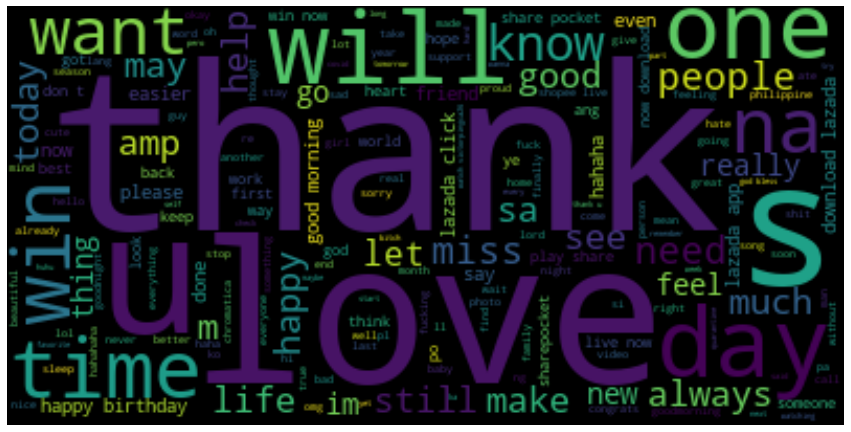

In [18]:
from wordcloud import WordCloud

all_words = " ".join([sentence for sentence in texts])
word_cloud = WordCloud().generate(all_words)
plt.figure(figsize=(15, 8))
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [20]:
tokens = nltk.word_tokenize(all_words)
tokens

['bridgetowne',
 'yow',
 'one',
 'of',
 'my',
 'fav',
 '#',
 'baekhyun',
 '#',
 'exo',
 '#',
 'weareoneexo',
 '#',
 'delight',
 '#',
 'candy',
 'loveyou',
 '!',
 '!',
 '!',
 'byeee',
 'imma',
 'listen',
 'to',
 'the',
 'b',
 'tracks',
 '#',
 'delight',
 '0',
 '9',
 '3',
 '0',
 '3',
 '1',
 '8',
 '8',
 '6',
 '8',
 '1',
 'maripol',
 'sebastian',
 'las',
 'pi',
 'as',
 'city',
 '#',
 'shopee',
 '#',
 'frontrow',
 '#',
 'gencee',
 '#',
 'plemex',
 'salamat',
 'po',
 'plemex',
 'cutie',
 'pie',
 'baby',
 'face',
 'gorgeous',
 '!',
 '!',
 '0',
 '9',
 '3',
 '0',
 '3',
 '1',
 '8',
 '8',
 '6',
 '8',
 '1',
 'maripol',
 'sebastian',
 'las',
 'pi',
 'as',
 'city',
 '#',
 'shopee',
 '#',
 'frontrow',
 '#',
 'gencee',
 '#',
 'plemex',
 'salamat',
 'gencee',
 'no',
 'empty',
 'carbs',
 'day',
 'starts',
 'tomorrow',
 '!',
 'help',
 'me',
 '.',
 'hahaha',
 'every',
 'wait',
 'has',
 'a',
 'worth',
 'snack',
 'time',
 'from',
 'mcdonald',
 "'s",
 'when',
 'we',
 'crave',
 'for',
 'cheeseburger',
 'mcdo'

In [21]:
len(tokens)

833381

In [24]:
from nltk.probability import FreqDist

f_dist = FreqDist()
for token in tokens:
    f_dist[token] += 1
f_dist.most_common(20)

[('.', 47402),
 ('!', 29495),
 ('#', 20958),
 ('i', 19802),
 ('the', 17861),
 ('to', 16467),
 ('you', 14718),
 ('and', 12063),
 ('a', 9209),
 ('of', 8206),
 ('is', 7858),
 ('for', 7832),
 ('my', 7023),
 ('it', 6893),
 ('in', 6008),
 ('this', 5740),
 ('me', 5532),
 ('that', 4991),
 ("'s", 4340),
 ('be', 4106)]